## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib qt
from moviepy.editor import VideoFileClip

In [2]:
# prepare object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)
#cv2.destroyAllWindows()

In [3]:
def undistort_image(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [4]:
def show_undistorted_image(image_path):
    image = mpimg.imread(image_path)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    f.tight_layout()
    ax1.set_title('Original Image', fontsize=25)
    ax1.imshow(image)
    ax2.set_title('Undistorted Image', fontsize=25)
    ax2.imshow(undistort_image(image, objpoints, imgpoints))
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

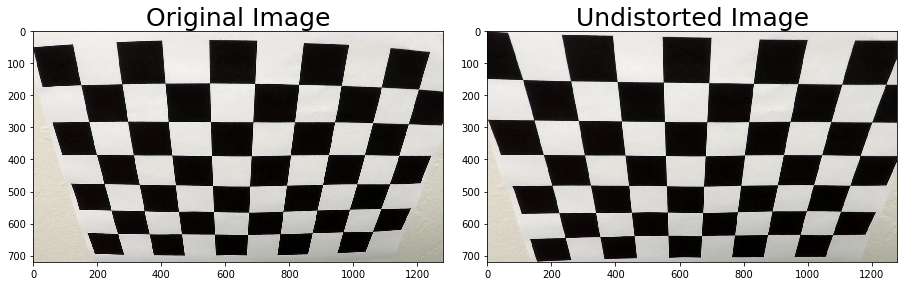

In [5]:
show_undistorted_image('../camera_cal/calibration2.jpg')

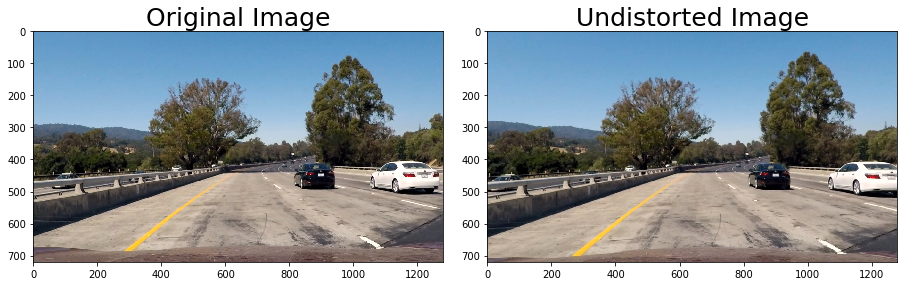

In [6]:
show_undistorted_image('../test_images/test1.jpg')

In [7]:
ksize = 3

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    if orient == 'x':
        d = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        d = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    abs_d = np.absolute(d)
    scaled = np.uint8(255*abs_d/np.max(abs_d))
    
    binary_output = np.zeros_like(scaled)
    binary_output[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    mag = np.sqrt(sobelx **2 + sobely ** 2)
    
    scaled_sobel = np.uint8(255*mag/np.max(mag))

    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_x = np.absolute(sobelx)
    abs_y = np.absolute(sobely)

    dir = np.arctan2(abs_y, abs_x)
    
    binary_output = np.zeros_like(dir)
    binary_output[(dir >= thresh[0]) & (dir <= thresh[1])] = 1
    return binary_output

def hls_channel_threshold(img, channel="h", thresh = (0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if channel == 'h':
        channel_data = hls[:,:,0]
    elif channel == 'l':
        channel_data = hls[:,:,1]
    else:
        channel_data = hls[:,:,2]
    
    binary = np.zeros_like(channel_data)
    binary[(channel_data >= thresh[0]) & (channel_data <= thresh[1])] = 1

    return binary

def rgb_channel_threshold(img, channel="r", thresh = (0, 255)):
    if channel == 'r':
        channel_data = img[:,:,0]
    elif channel == 'g':
        channel_data = img[:,:,1]
    else:
        channel_data = img[:,:,2]
    
    binary = np.zeros_like(channel_data)
    binary[(channel_data >= thresh[0]) & (channel_data <= thresh[1])] = 1

    return binary

def hsv_channel_threshold(img, channel="h", thresh = (0, 255)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if channel == 'h':
        channel_data = hsv[:,:,0]
    elif channel == 's':
        channel_data = hsv[:,:,1]
    else:
        channel_data = hsv[:,:,2]
    
    binary = np.zeros_like(channel_data)
    binary[(channel_data >= thresh[0]) & (channel_data <= thresh[1])] = 1

    return binary

In [ ]:
def undistorted_image(image_path):
    image = mpimg.imread(image_path)
    return cal_undistort(image, objpoints, imgpoints)

In [ ]:
def show_before_and_after(before_image, after_image, before_title = "Before", after_title="After"):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    f.tight_layout()
    if len(before_image.shape) == 3:
        ax1.imshow(before_image)
    else:
        ax1.imshow(before_image, cmap='gray')
    ax1.set_title(before_title, fontsize=20)
    if len(after_image.shape) == 3:
        ax2.imshow(after_image)
    else:
        ax2.imshow(after_image, cmap='gray')
    ax2.set_title(after_title, fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
# RESULT
#hls_channel_threshold(image, 's', thresh=(x, y)) --> 120, 255
#hsv doesn't work
#rgb_channel_threshold(image, 'r', thresh=(x, y)) --> 225, 255
#rgb_channel_threshold(image, 'g', thresh=(x, y)) --> 210, 255
# b --> doesn't work
#mag_thresh --> 80,220
#abs_sobel_thresh(image, orient='x', sobel_kernel=5, thresh=(x, y)) --> 30,200
#abs_sobel_thresh(image, orient='x', sobel_kernel=7, thresh=(x, y)) --> 10, 40
#abs_sobel_thresh(image, orient='y', sobel_kernel=3, thresh=(x, y)) --> 30,200
#abs_sobel_thresh(image, orient='y', sobel_kernel=7, thresh=(x, y)) -> 50, 150

In [ ]:
from ipywidgets import widgets
from ipywidgets import interact

image = undistorted_image('../test_images/test6.jpg')

def f(x, y):
    #hls_binary = hls_channel_threshold(image, 's', thresh=(x, y))
    #hsv_binary = hsv_channel_threshold(image, 'v', thresh=(x, y))    
    #rgb_binary = rgb_channel_threshold(image, 'b', thresh=(x, y))    
    #mag_thresh_binary = mag_thresh(image, sobel_kernel = 3, mag_thresh=(x, y))
    
    dir_binary = dir_threshold(image, sobel_kernel = x, thresh=(0.5, 1.3))
    
    #grady = abs_sobel_thresh(image, orient='x', sobel_kernel=7, thresh=(x, y))
    
    show_before_and_after(image, dir_binary, before_title="Original", after_title="Sat Threshold")

interact(f, x=widgets.IntSlider(min=3,max=21,step=2,value=21, continuous_update=False, description="Min Color:"),
              y=widgets.IntSlider(min=0,max=255,step=1,value=200, continuous_update=False, description="Max Color:"))

In [ ]:
# WARP IMAGE
# Vertices extracted manually for performing a perspective transform
image = undistorted_image('../test_images/test4.jpg')

image_shape = image.shape
bottom_left = [150,720]
bottom_right = [1130, 720]
top_left = [540, 480]
top_right = [762, 480]

source = np.float32([bottom_left,bottom_right,top_right,top_left])

pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
pts = pts.reshape((-1,1,2))
copy = image.copy()
cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)

# Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
bottom_left = [320,720]
bottom_right = [920, 720]
top_left = [320, 1]
top_right = [920, 1]

dst = np.float32([bottom_left,bottom_right,top_right,top_left])
M = cv2.getPerspectiveTransform(source, dst)
M_inv = cv2.getPerspectiveTransform(dst, source)
img_size = (image_shape[1], image_shape[0])

warped = cv2.warpPerspective(image, M, img_size)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(copy)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
def warp_image(image, source, dest):
    image_shape = image.shape
    M = cv2.getPerspectiveTransform(source, dest)
    M_inverse = cv2.getPerspectiveTransform(dest, source)
    img_size = (image_shape[1], image_shape[0])

    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M_inverse

In [ ]:
def select_rgb_white_yellow(image): 
    # white color mask
    lower = np.uint8([220, 220, 220])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
    # yellow color mask
    #lower = np.uint8([190, 190,   0])
    #lower = np.uint8([170, 170, 0]) <-- final project
    lower = np.uint8([130, 130, 0]) #<-- challenge video
    upper = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    
    return masked

In [ ]:
def get_vertices(image):
    imshape = image.shape
    #print(imshape)
    #return np.array([[(120,imshape[0]),(420, 330), (imshape[1] - 420, 330), (imshape[1]-50,imshape[0])]], dtype=np.int32)
    bottom_left = [180,720]
    bottom_right = [1230, 720]
    top_left = [500, 450]
    top_right = [762, 450]
    return np.array([[bottom_left,top_left,top_right, bottom_right]], dtype=np.int32) 

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [ ]:
def pipeline(image):
    # Undistort
    img_undistort = cal_undistort(image, objpoints, imgpoints)
    
    # Region of interest
    #roi_image = region_of_interest(img_undistort, get_vertices(img_undistort))
    roi_image = region_of_interest(img_undistort, get_vertices_challenge(img_undistort))
    
    
    # Apply mask
    masked_image = select_rgb_white_yellow(roi_image)
    #masked_image = select_rgb_white_yellow(img_undistort)
    #masked_image = roi_image
    #print(masked_image.shape)    
    
    # HLS S channel
    hls_binary = hls_channel_threshold(masked_image, 's', thresh=(120, 255))
    
    # RGB R channel
    rgb_r_binary = rgb_channel_threshold(masked_image, 'r', thresh=(225, 255))
    
    # RGB G channel
    rgb_g_binary = rgb_channel_threshold(masked_image, 'g', thresh=(210, 255))
    
    # Magnitude threshold
    mag_thresh_binary = mag_thresh(masked_image, sobel_kernel = 3, mag_thresh=(80,220))
        
    # Sobel X, kernel 5
    sobelX_K5_binary = abs_sobel_thresh(masked_image, orient='x', sobel_kernel=5, thresh=(30,200))
    
    # Sobel X, kernel 7
    sobelX_K7_binary = abs_sobel_thresh(masked_image, orient='x', sobel_kernel=7, thresh=(10, 40))
    
    # Sobel Y, kernel 3
    sobelY_K3_binary = abs_sobel_thresh(masked_image, orient='y', sobel_kernel=3, thresh=(30,200))
    
    # Sobel Y, kernel 7
    sobelY_K7_binary = abs_sobel_thresh(masked_image, orient='y', sobel_kernel=7, thresh=(50, 150))
    
    # Direction Gradient
    dir_binary = dir_threshold(masked_image, sobel_kernel = 21, thresh=(0.5, 1.3))
    
    # Combine all thresholds
    combined = np.zeros_like(hls_binary)
    #combined[(hls_binary ==1) | (rgb_r_binary == 1) | (rgb_g_binary == 1)| mag_thresh_binary | sobelX_K5_binary | sobelX_K7_binary | sobelY_K3_binary | sobelY_K7_binary | dir_binary] = 1
    combined[(hls_binary == 1) | (rgb_r_binary == 1) | (rgb_g_binary == 1) | ( mag_thresh_binary == 1)
            | (sobelX_K5_binary == 1) | (sobelX_K7_binary == 1) | (sobelY_K3_binary == 1) | (sobelY_K7_binary == 1)] = 1
    
    #combined[hls_binary | rgb_r_binary | rgb_g_binary | mag_thresh_binary
    #    | sobelX_K5_binary | sobelX_K7_binary | sobelY_K3_binary | sobelY_K7_binary] = 1

    
    #print(combined)
    #print(combined.shape)
    #color_warp = np.dstack((combined, combined, combined))*255
    
    color_warp = np.uint8(np.dstack((combined, combined, combined))*255)
    
    #binary_warp = np.dstack((combined, combined, combined))*255
                            
    # Perspective Transform
    image_shape = image.shape
    bottom_left = [150,720]
    bottom_right = [1130, 720]
    top_left = [540, 480]
    top_right = [762, 480]
    source = np.float32([bottom_left,bottom_right,top_right,top_left])
    
    bottom_left = [320,720]
    bottom_right = [920, 720]
    top_left = [320, 1]
    top_right = [920, 1]
    dst = np.float32([bottom_left,bottom_right,top_right,top_left])
    
    img_warped, M_inverse = warp_image(color_warp, source, dst)    
    #print(img_warped.shape)
    #return roi_image
    gray = cv2.cvtColor(img_warped, cv2.COLOR_RGB2GRAY)
    return gray, M_inverse

In [ ]:
def show_2_images(left, right):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(left)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(right)
    ax2.set_title('Final Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
def get_vertices_challenge(image):
    imshape = image.shape
    #print(imshape)
    #return np.array([[(120,imshape[0]),(420, 330), (imshape[1] - 420, 330), (imshape[1]-50,imshape[0])]], dtype=np.int32)
    bottom_left = [180,720]
    bottom_right = [1180, 720]
    top_left = [530, 500]
    top_right = [762, 500]
    return np.array([[bottom_left,top_left,top_right, bottom_right]], dtype=np.int32) 

In [ ]:
#image = mpimg.imread('../test_images/test5.jpg')
#image_shape = image.shape
#warped,M_inverse = pipeline(image)



image = mpimg.imread('./test_images/1.5.jpg')
img_undistort = cal_undistort(image, objpoints, imgpoints)
# Region of interest
roi_image = region_of_interest(img_undistort, get_vertices_challenge(img_undistort))
masked_image = select_rgb_white_yellow(roi_image)
show_2_images(img_undistort, masked_image)


In [ ]:
def process_image_folder(folder_path):
    images = glob.glob(folder_path)

    # Set up plot
    fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
    fig.subplots_adjust(hspace = .2, wspace=.001)
    axs = axs.ravel()

    i = 0
    for image in images:
        print(image)
        img = mpimg.imread(image)
        img_bin, tmp = pipeline(img)
        axs[i].imshow(img)
        axs[i].axis('off')
        i += 1
        axs[i].imshow(img_bin, cmap='gray')
        axs[i].axis('off')
        i += 1

In [ ]:
process_image_folder('./test_images/*.jpg')

In [ ]:
# Define method to fit polynomial to binary image with lines extracted, using sliding window
def sliding_window_polyfit(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    #print(histogram.shape)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    #print(midpoint)
    quarter_point = np.int(midpoint//2)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    #leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    #rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    leftx_base = np.argmax(histogram[:midpoint])
    #print(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    #print('base pts:', leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    #print(nonzero.shape)
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data

In [ ]:
exampleImg = mpimg.imread('./test_images/1.5.jpg')
exampleImg_bin, M_inverse = pipeline(exampleImg)
print(exampleImg_bin.shape)
binary_image = exampleImg_bin / 255 


histogram = np.sum(binary_image[binary_image.shape[0]//2:,:], axis=0)

plt.plot(histogram)

In [ ]:
# visualize the result on example image
exampleImg = mpimg.imread('./test_images/23.3.jpg')
exampleImg_bin, M_inverse = pipeline(exampleImg)
print(exampleImg_bin.shape)
binary_image = exampleImg_bin / 255 


histogram = np.sum(binary_image[binary_image.shape[0]//2:,:], axis=0)

plt.plot(histogram)
    
left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(exampleImg_bin)
#histogram = sliding_window_polyfit(exampleImg_bin)
#plt.plot(histogram)

h = exampleImg.shape[0]
#print(left_lane_inds)
left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
#print('fit x-intercepts:', left_fit_x_int, right_fit_x_int)

rectangles = visualization_data[0]
histogram = visualization_data[1]

# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((exampleImg_bin, exampleImg_bin, exampleImg_bin))*255)
# Generate x and y values for plotting
ploty = np.linspace(0, exampleImg_bin.shape[0]-1, exampleImg_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
for rect in rectangles:
# Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
# Identify the x and y positions of all nonzero pixels in the image
nonzero = exampleImg_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [ ]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(binary_image)

# View your output
plt.imshow(result)

In [ ]:
# Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist
print('...')

In [ ]:
rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(binary_image, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for example:', d_center, 'm')

In [ ]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result
print('...')

In [ ]:
exampleImg_out1 = draw_lane(exampleImg, binary_image, left_fit, right_fit, M_inverse)
plt.imshow(exampleImg_out1)
print('...')

In [ ]:
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (300,70), font, 1.5, (0, 0, 255), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = 'Estimated {:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (240,120), font, 1.5, (0, 0, 255), 2, cv2.LINE_AA)
    return new_img
print('...')

In [ ]:
exampleImg_out2 = draw_data(exampleImg_out1, (rad_l+rad_r)/2, d_center)
plt.imshow(exampleImg_out2)
print('...')

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)


            

print('...')

In [ ]:
def process_image(img):
    new_img = np.copy(img)
    img_bin, Minv = pipeline(new_img)
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window_polyfit(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        #print('Diff: ', l_fit_x_int, ', ', r_fit_x_int, ', ', x_int_diff)
        if abs(750 - x_int_diff) > 250:
            l_fit = None
            r_fit = None

    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
    
    diagnostic_output = False
    if diagnostic_output and l_fit is not None and r_fit is not None:
        # put together multi-view output
        diag_img = np.zeros((720,1280,3), dtype=np.uint8)
        
        # original output (top left)
        diag_img[0:360,0:640,:] = cv2.resize(img_out,(640,360))
        
        # binary overhead view (top right)
        img_bin = np.dstack((img_bin*255, img_bin*255, img_bin*255))
        resized_img_bin = cv2.resize(img_bin,(640,360))
        diag_img[0:360,640:1280, :] = resized_img_bin
        
        # overhead with all fits added (bottom right)
        img_bin_fit = np.copy(img_bin)
        for i, fit in enumerate(l_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (20*i+100,0,20*i+100))
        for i, fit in enumerate(r_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (0,20*i+100,20*i+100))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, l_line.best_fit, (255,255,0))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, r_line.best_fit, (255,255,0))
        diag_img[360:720,640:1280,:] = cv2.resize(img_bin_fit,(640,360))
        
        # diagnostic data (bottom left)
        color_ok = (200,255,155)
        color_bad = (255,155,155)
        font = cv2.FONT_HERSHEY_DUPLEX
        if l_fit is not None:
            text = 'This fit L: ' + ' {:0.6f}'.format(l_fit[0]) + \
                                    ' {:0.6f}'.format(l_fit[1]) + \
                                    ' {:0.6f}'.format(l_fit[2])
        else:
            text = 'This fit L: None'
        cv2.putText(diag_img, text, (40,380), font, .5, color_ok, 1, cv2.LINE_AA)
        if r_fit is not None:
            text = 'This fit R: ' + ' {:0.6f}'.format(r_fit[0]) + \
                                    ' {:0.6f}'.format(r_fit[1]) + \
                                    ' {:0.6f}'.format(r_fit[2])
        else:
            text = 'This fit R: None'
        cv2.putText(diag_img, text, (40,400), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit L: ' + ' {:0.6f}'.format(l_line.best_fit[0]) + \
                                ' {:0.6f}'.format(l_line.best_fit[1]) + \
                                ' {:0.6f}'.format(l_line.best_fit[2])
        cv2.putText(diag_img, text, (40,440), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit R: ' + ' {:0.6f}'.format(r_line.best_fit[0]) + \
                                ' {:0.6f}'.format(r_line.best_fit[1]) + \
                                ' {:0.6f}'.format(r_line.best_fit[2])
        cv2.putText(diag_img, text, (40,460), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Diffs L: ' + ' {:0.6f}'.format(l_line.diffs[0]) + \
                             ' {:0.6f}'.format(l_line.diffs[1]) + \
                             ' {:0.6f}'.format(l_line.diffs[2])
        if l_line.diffs[0] > 0.001 or \
           l_line.diffs[1] > 1.0 or \
           l_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,500), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Diffs R: ' + ' {:0.6f}'.format(r_line.diffs[0]) + \
                             ' {:0.6f}'.format(r_line.diffs[1]) + \
                             ' {:0.6f}'.format(r_line.diffs[2])
        if r_line.diffs[0] > 0.001 or \
           r_line.diffs[1] > 1.0 or \
           r_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,520), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Good fit count L:' + str(len(l_line.current_fit))
        cv2.putText(diag_img, text, (40,560), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Good fit count R:' + str(len(r_line.current_fit))
        cv2.putText(diag_img, text, (40,580), font, .5, color_ok, 1, cv2.LINE_AA)
        
        img_out = diag_img
    return img_out
print('...')

In [ ]:
def plot_fit_onto_img(img, fit, plot_color):
    if fit is None:
        return img
    new_img = np.copy(img)
    h = new_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    plotx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    pts = np.array([np.transpose(np.vstack([plotx, ploty]))])
    cv2.polylines(new_img, np.int32([pts]), isClosed=False, color=plot_color, thickness=8)
    return new_img
print('...')

In [ ]:
# Define method to fit polynomial to binary image based upon a previous fit (chronologically speaking);
# this assumes that the fit will not change significantly from one video frame to the next
def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds
print('...')

In [ ]:
l_line = Line()
r_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'challenge_video_output.mp4'
video_input1 = VideoFileClip('../challenge_video.mp4')#.subclip(20,32)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

In [ ]:
import os
def extract_frames(movie, times, imgdir):
    clip = VideoFileClip(movie)
    for t in times:
        imgpath = os.path.join(imgdir, '{}.jpg'.format(t))
        clip.save_frame(imgpath, t)

movie = '../challenge_video.mp4'
imgdir = 'test_images'
times = 1.1, 1.5, 1.8, 1.9, 2.2, 2.4, 2.6

extract_frames(movie, times, imgdir)

## And so on and so forth...

In [2]:
# THIS IS FOR CAR DETECTION PROJECT
from moviepy.editor import VideoFileClip
import os
def extract_frames(movie, times, imgdir):
    clip = VideoFileClip(movie)
    for t in times:
        imgpath = os.path.join(imgdir, '{}.jpg'.format(t))
        clip.save_frame(imgpath, t)

movie = './project_video.mp4'
imgdir = 'fix'
times = 16.9, 17, 17.1, 17.2, 17.3, 17.4, 17.5, 17.6

extract_frames(movie, times, imgdir)